<a href="https://colab.research.google.com/github/rahmani3101/Deep-Fake-Detection-/blob/master/Deep_fake_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ciplab/real-and-fake-face-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/real-and-fake-face-detection


In [2]:
import pandas as pd
import os
from google.colab import drive

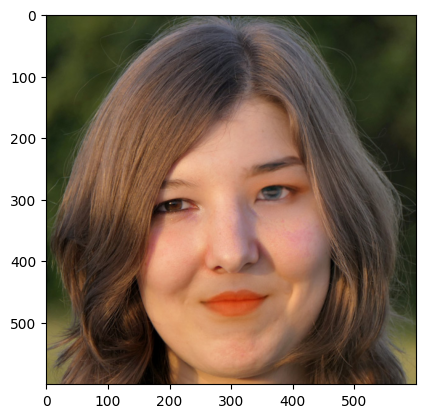

In [4]:
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_102_0101.jpg').convert('RGB')
plt.imshow(img)

In [9]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import random
%matplotlib inline
import cv2

In [13]:
image_size = 224
labels = ('training_real', 'training_fake')
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                resized_arr = cv2.resize(img_arr, (image_size, image_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    return np.array(data, dtype='object')

train = get_data("/kaggle/input/real-and-fake-face-detection/real_and_fake_face/")
test = get_data("/kaggle/input/real-and-fake-face-detection/real_and_fake_face/")
print(train.shape)
print(test.shape)

(2041, 2)
(2041, 2)


In [14]:
l = []
for i in train:
    if i[1] == 0:
        l.append('real')
    else:
        l.append('fake')

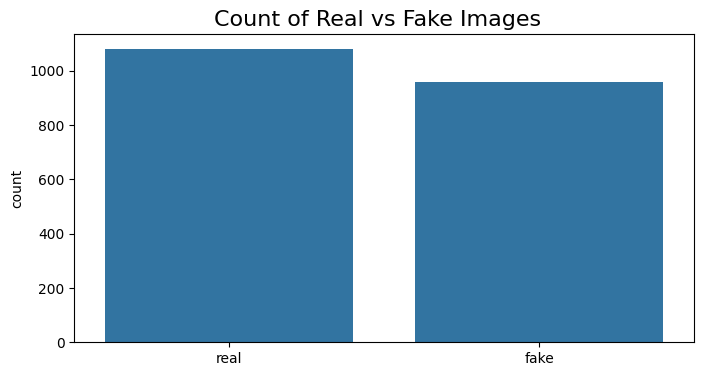

In [19]:
plt.figure(figsize=(8, 4))
plt.title('Count of Real vs Fake Images  ', size=16)
sns.countplot(x=l)
plt.show()

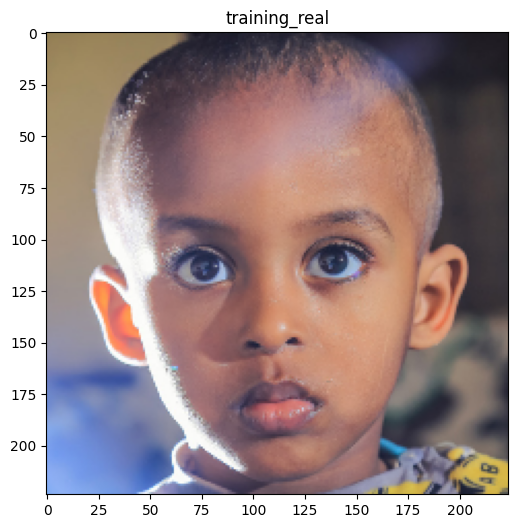

In [18]:
# randomly visualizing images
plt.figure(figsize=(8, 6))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])
plt.show()


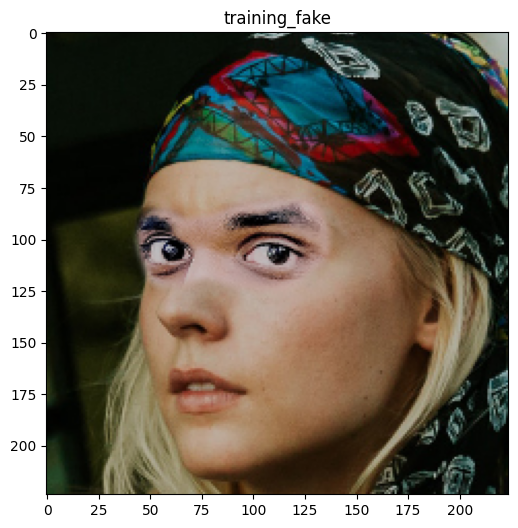

In [20]:
plt.figure(figsize=(10, 6))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])
plt.show()

In [21]:
X_train = []
X_test = []
y_train = []
y_test = []

In [22]:
# dividing data into train and test sets
for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

In [23]:
# Normalise the image data
X_train = np.array(X_train)
X_test = np.array(X_test)

In [24]:
# # Reshaping the image data so that every image is the same size
y_train = np.array(y_train)
y_test = np.array(y_test)

In [25]:
y_test = np.array(y_test)
print (X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2041, 224, 224, 3)
(2041, 224, 224, 3)
(2041,)
(2041,)


In [27]:
!pip install -U tensorflow-addons

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

ModuleNotFoundError: No module named 'tensorflow_addons'

In [29]:
num_classes = 2
input_shape = (224, 224, 3)

Vision Tranform parameter

In [30]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 80
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2 , projection_dim,]

In [31]:
transformer_layers = 8
mlp_head_units = [2048, 1024]



Data Augmentation to calculate mean and variance


In [32]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(X_train)

In [33]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x



In [34]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


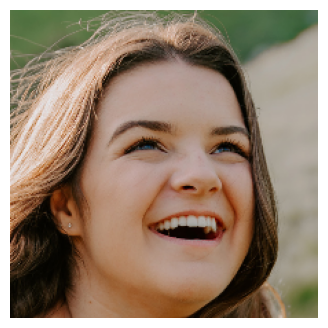

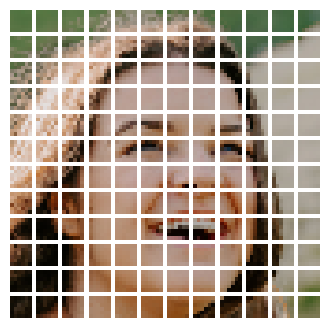

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [36]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [37]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add multilayer perceptron.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

In [40]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [43]:
def run_experiment(model):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
    )
    predictions = np.argmax(model.predict(X_test), axis=-1)

# Regain the original shape to evaluate predictions
    predictions = predictions.reshape(1, -1)[0]

    # Print classification report
    print(classification_report(y_test, predictions, target_names=['Healthy(class 0)', 'UnHealthy(class 1)']))
    print("Accuracy: ", metrics.accuracy_score(y_test, predictions) * 100)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs) # Use num_epochs instead of hardcoded 50

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    #building the confusion matrix
    result = confusion_matrix(y_test, predictions , normalize='pred')
    print(result)
    labels = ["Fake", "Real"]
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    return history


Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 604ms/step - accuracy: 0.5190 - loss: 4.9534 - top-5-accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0578 - val_top-5-accuracy: 1.0000
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.5017 - loss: 1.4374 - top-5-accuracy: 1.0000 - val_accuracy: 0.5268 - val_loss: 0.7873 - val_top-5-accuracy: 1.0000
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.5248 - loss: 0.9458 - top-5-accuracy: 1.0000 - val_accuracy: 0.3512 - val_loss: 0.7933 - val_top-5-accuracy: 1.0000
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.5769 - loss: 0.7719 - top-5-accuracy: 1.0000 - val_accuracy: 0.5073 - val_loss: 0.7187 - val_top-5-accuracy: 1.0000
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - accuracy: 0.5573 - loss: 0.7290 - top-5-accuracy: 1.0000 - val_accuracy: 0.1463 - val_loss: 0.9021 - val_top-5-accuracy: 1.0000
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - accuracy: 0.5713 - loss: 0.7424 - top-5-accurac

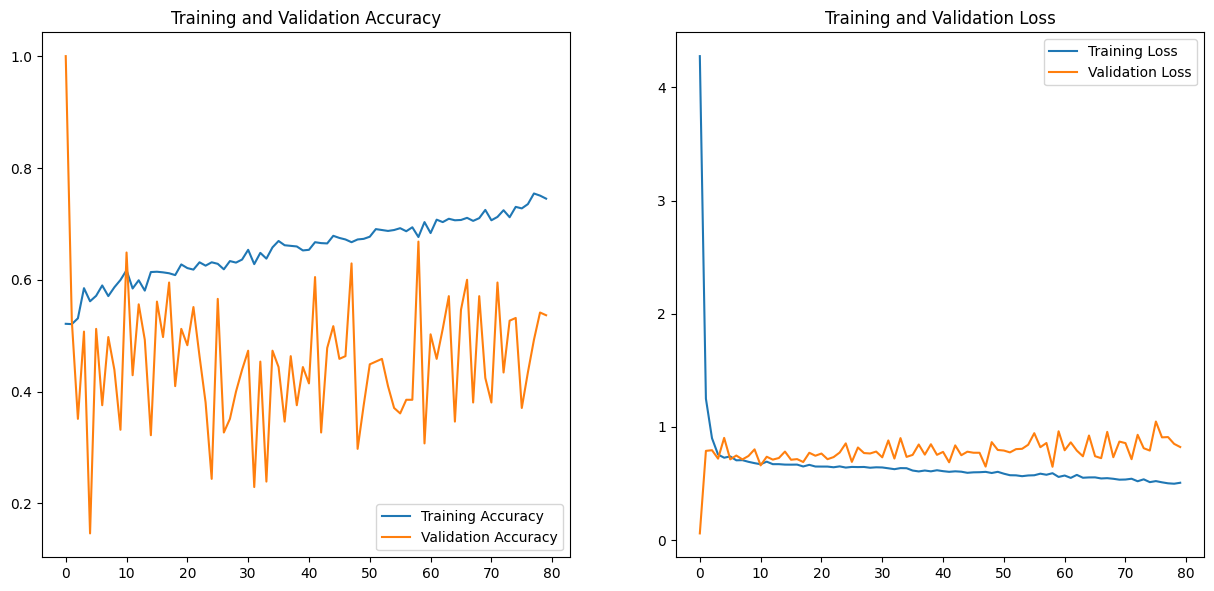

[[0.8117752  0.18586957]
 [0.1882248  0.81413043]]


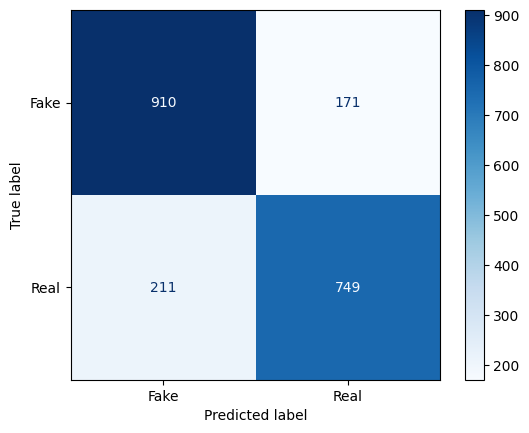

In [44]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5286 - loss: 0.7028 - val_accuracy: 0.6384 - val_loss: 0.6384
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 70s 537ms/step - accuracy: 0.6336 - loss: 0.6410 - val_accuracy: 0.6673 - val_loss: 0.6101
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 539ms/step - accuracy: 0.6537 - loss: 0.6190 - val_accuracy: 0.6850 - val_loss: 0.5985
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 541ms/step - accuracy: 0.6688 - loss: 0.5993 - val_accuracy: 0.6781 - val_loss: 0.5887
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 542ms/step - accuracy: 0.6540 - loss: 0.6143 - val_accuracy: 0.6894 - val_loss: 0.5753
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.6904 - loss: 0.5869 - val_accuracy: 0.7129 - val_loss: 0.5591
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 543ms/step - accuracy: 0.6868 - loss: 0.5846 - val_accuracy: 0.7202 - val_loss: 0.5536
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 543ms/step - accuracy: 0.7013 - loss: 0.5720 - val_accura

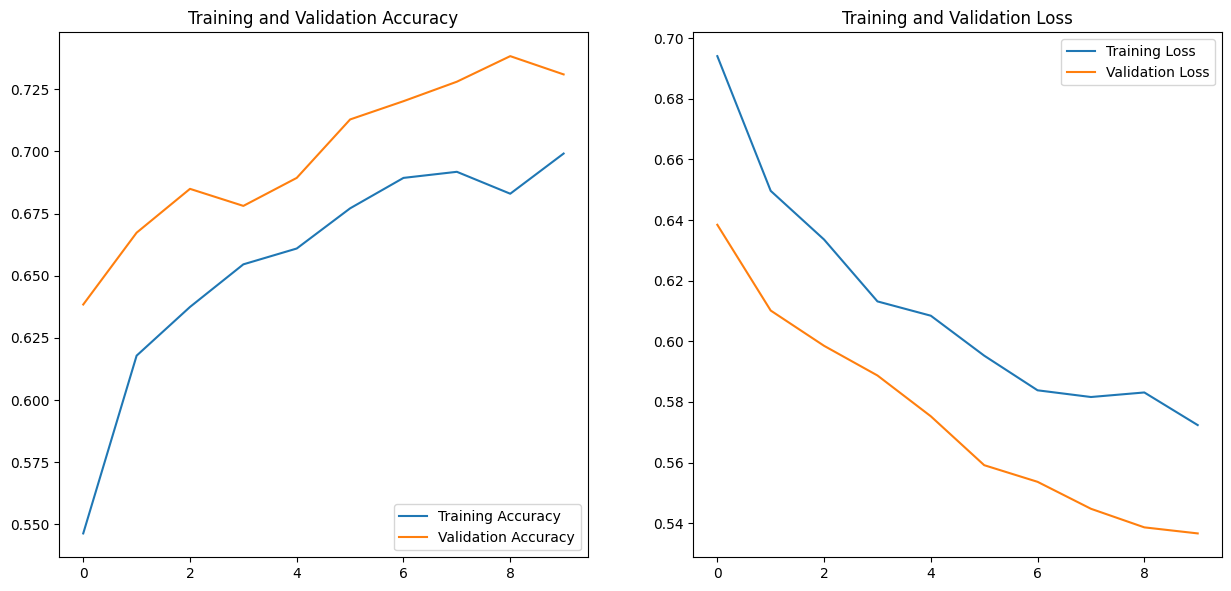

In [46]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model.trainable = False

# keras tuner to find the best architecture
model = tf.keras.Sequential([base_model, tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(2, activation='softmax')])

model.compile(optimizer=keras.optimizers.Adam(0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# callback for early stopping
# patience is the number of epochs wth no improvement after which the training will be stopped
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

predictions = np.argmax(model.predict(X_test), axis=-1)
predictions = predictions.reshape(1, -1)[0]

# print the classification report
print(classification_report(y_test, predictions, target_names=['real(class 0)', 'fake(class 1)']))
print("Accuracy: ", metrics.accuracy_score(y_test, predictions) * 100)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10) # Changed to 10 to match the number of epochs in model.fit

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
model.save("asad.h5")

AttributeError: 'NoneType' object has no attribute 'save'

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


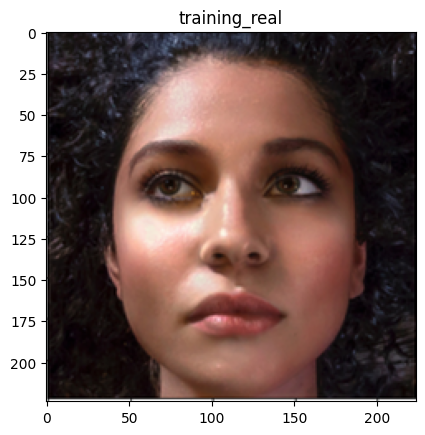

Class: training_real , Confidence score: 0.7609277


In [64]:
from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

# Load the model
model = load_model('asad.h5', compile=False)

class_names = labels

data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
for i in range(1,):
    image = Image.open(f"/Screenshot From 2025-08-20 22-15-18.png").convert('RGB')
    #resizing the image to be at least 224x224 and then cropping from the center
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

    #turn the image into a numpy array
    image_array = np.asarray(image)

    # Normalize the image
    normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

    # Load the image into the array
    data[0] = normalized_image_array

    # predict
    prediction = model.predict(data)
    index = np.argmax(prediction)
    class_name = class_names[index]
    plt.imshow(image)
    plt.title(class_name)
    plt.show()

    confidence_score = prediction[0][index]

    print('Class:', class_name, end=' , ')
    print('Confidence score:', confidence_score)